In [1]:
# Standford Research SR844 example
from time import sleep

import numpy as np

from qcodes.dataset import do0d, do1d, do2d, load_or_create_experiment
from qcodes.instrument.parameter import ParameterWithSetpoints
from qcodes.utils import validators
from qcodes_contrib_drivers.drivers.StanfordResearchSystems.SR844 import SR844

In [2]:
lockin1 = SR844('lockin', 'GPIB0::3::INSTR')
exp = load_or_create_experiment(experiment_name='SR844_notebook__')

Connected to: Stanford_Research_Systems SR844 (serial:s/n49388, firmware:ver1.006) in 0.79s


Let's quickly look at the status of the instrument after connecting to it:

In [3]:
lockin1.print_readable_snapshot()

lockin:
	parameter       value
--------------------------------------------------------------------------------
IDN              :	{'vendor': 'Stanford_Research_Systems', 'model': 'SR844', ...
R_V              :	None (V)
R_V_offset       :	None (% of full scale)
R_dBm            :	None (dBm)
R_dBm_offset     :	None (% of 200 dBm scale)
X                :	None (V)
X_offset         :	None (% of full scale)
Y                :	None (V)
Y_offset         :	None (% of full scale)
aux_in1          :	None (V)
aux_in2          :	None (V)
aux_out1         :	None (V)
aux_out2         :	None (V)
buffer_SR        :	Trigger (Hz)
buffer_acq_mode  :	None 
buffer_npts      :	None 
buffer_trig_mode :	None 
ch1              :	None (V)
ch1_datatrace    :	Not available (V)
ch1_display      :	R_V 
ch2              :	None (V)
ch2_datatrace    :	Not available (deg)
ch2_display      :	Phase 
complex_voltage  :	None (V)
filter_slope     :	None (dB/oct)
frequency        :	None (Hz)
harmonic         :	None 
input_

In [4]:
lockin1.complex_voltage()

(0.00901563+0.0074385j)

In fact, a method name `snap` is available on the SR844 lockin which allows the user to read 2 to 6 parameters simultaneously out of the following.

In [3]:
from pprint import pprint

pprint(list(lockin1.SNAP_PARAMETERS.keys()))

['x',
 'y',
 'r_v',
 'r_dbm',
 'p',
 'phase',
 'θ',
 'aux1',
 'aux2',
 'freq',
 'ch1',
 'ch2']


The `snap` method can be used in the following manner

In [6]:
lockin1.snap('x', 'y', 'phase')

(0.00901262, 0.00744152, 39.5453)

### Changing the Sensitivity
The driver can change the sensitivity automatically according to the R value of the lock-in.
So instead of manually changing the sensitivity on the front panel, you can simply run this in your data acquisition or Measurement

In [7]:
lockin1.auto_gain()

You can get and set your sensitivity using the sensitivity attribute

In [8]:
lockin1.sensitivity(0.03)
lockin1.sensitivity()

0.03

The driver also supports incremental changes in sensitivity

In [9]:
lockin1.increment_sensitivity()

0.1

In [10]:
lockin1.decrement_sensitivity()

0.03

### Preparing for reading the buffer and measurement

The SR844 has two internal data buffers corresponding to the values on the displays of channel 1 and channel 2.
Here we present a simple way to use the buffers.
The buffer can be filled either at a constant sampling rate or by sending an trigger. 
Each buffer can hold 16383 points. The buffers are filled simultaneously. The QCoDeS driver always pulls the entire buffer, so make sure to reset (clear) the buffer of old data before starting and acquisition.

We setup channel 1 and the buffer to be filled at a constant sampling rate:

In [71]:
lockin1.ch1_display('X')
lockin1.ratio_mode('none')
lockin1.buffer_SR(512)  # Sample rate (SR)
lockin1.buffer_trig_mode.set('OFF')

We fill the buffer for one second as shown below:

In [72]:
lockin1.buffer_reset()
lockin1.buffer_start()
sleep(1)
lockin1.buffer_pause() 

Now we run a QCoDeS Measurement using do0d to get the buffer and plot it:

Starting experimental run with id: 556. Using 'qcodes.dataset.do0d'


(results #556@C:\Users\Farzad\experiments.db
 -------------------------------------------
 lockin_sweep_setpoints - array
 lockin_ch1_datatrace - array,
 (<Axes: title={'center': 'Run #556, Experiment SR844_notebook__ (some_sample)'}, xlabel='Time (ms)', ylabel='X (μV)'>,),
 (None,))

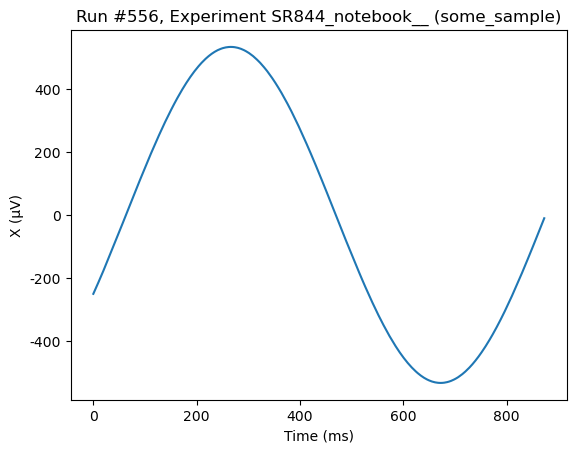

In [73]:
do0d(lockin1.ch1_datatrace, do_plot=True)

#### Measurements using trigger

In [ ]:
lockin1.ch1_display('R_V')
lockin1.ratio_mode('none')

We need to set up the lock-in to use the trigger

In [83]:
lockin1.buffer_SR("Trigger")
lockin1.buffer_trig_mode.set('ON')

We need to connect the data points stored in the buffer to the corresponding values of the sweep parameter for which the data was taken,
i.e we need to give the set points.
For this purpose the driver has the convinence function set_sweep_parameters, that generates the set point with units and labels corresponding to the independent parameter here frequency.

In [84]:
lockin1.set_sweep_parameters(lockin1.frequency, 25000, 35000, 101)

To fill the buffer we iterate through values of the sweep_setpoints and change the value of the frequency followed by a trigger statement. To get and plot the data we use the do0d.

In [85]:
lockin1.buffer_reset()
for v in lockin1.sweep_setpoints.get():
    lockin1.frequency(v)
    sleep(0.05)
    lockin1.send_trigger()

Starting experimental run with id: 558. Using 'qcodes.dataset.do0d'


(results #558@C:\Users\Farzad\experiments.db
 -------------------------------------------
 lockin_sweep_setpoints - array
 lockin_ch1_datatrace - array,
 (<Axes: title={'center': 'Run #558, Experiment SR844_notebook__ (some_sample)'}, xlabel='Frequency (kHz)', ylabel='R_V (μV)'>,),
 (None,))

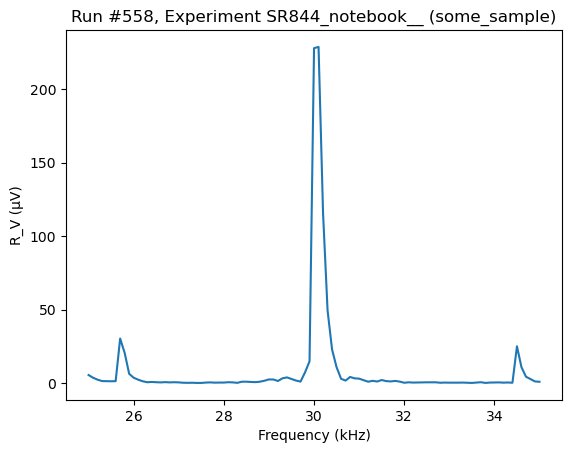

In [86]:
do0d(lockin1.ch1_datatrace, do_plot=True)

We are not restricted to sample on an equally spaced grid. We can set the sweep_array directly.

In [91]:
grid_sample = np.concatenate((np.linspace(25000, 29000, 10), np.linspace(29300, 35000, 91)))
lockin1.sweep_setpoints.sweep_array = grid_sample

In [92]:
lockin1.buffer_reset()
for v in lockin1.sweep_setpoints.get():
    lockin1.frequency(v)
    sleep(0.05)
    lockin1.send_trigger()

Starting experimental run with id: 560. Using 'qcodes.dataset.do0d'


(results #560@C:\Users\Farzad\experiments.db
 -------------------------------------------
 lockin_sweep_setpoints - array
 lockin_ch1_datatrace - array,
 (<Axes: title={'center': 'Run #560, Experiment SR844_notebook__ (some_sample)'}, xlabel='frequency (kHz)', ylabel='R_V (μV)'>,),
 (None,))

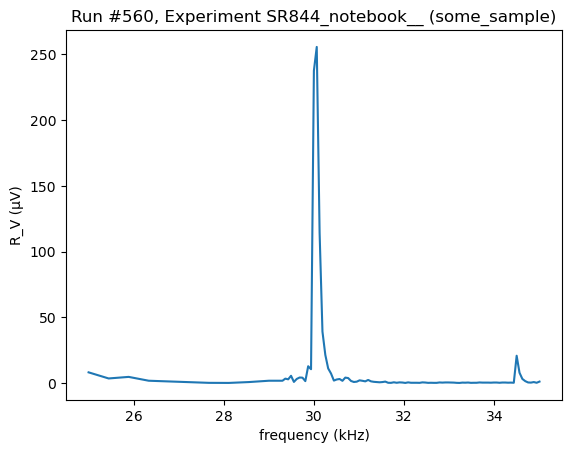

In [93]:
do0d(lockin1.ch1_datatrace, do_plot=True)

We can also construct `2d`-maps using buffer readout. Let's make an object which runs the measurement on the fast axis and returns the channel 1 buffer

In [139]:
class Fast_Axis(ParameterWithSetpoints):
    
    def __init__(self, name, measurement_instrument, sweeper, wait_fast):
        self.measurement_instrument = measurement_instrument
        self.measurment_label = measurement_instrument.ch1_display()
        self.measurement_var = getattr(self.measurement_instrument, measurement_instrument.ch1_display())
        self.sweeper = sweeper
        self.wait_fast = wait_fast

        super().__init__(name, label=self.measurment_label, unit=self.measurement_var.unit,
                        vals=validators.Arrays(shape=(self.measurement_instrument.buffer_npts.get,)),
                        setpoints=(self.measurement_instrument.sweep_setpoints,),
                        docstring='Constructs a buffer measurement over the aux out 1 axis')
    
    def meas(self):
        self.measurement_instrument.buffer_reset()
        for y in self.measurement_instrument.sweep_setpoints.get():
            self.sweeper(y)
            sleep(self.wait_fast)
            self.measurement_instrument.send_trigger()

    def get_raw(self):
        self.meas()
        sleep(0.005) # crucial to avoid buffer readout error
        return self.measurement_instrument.ch1_datatrace()
    

The instrument should be loaded with the setpoints on the fast axis before creating the Spectrum object

In [140]:
lockin1.ch1_display('R_V')
lockin1.ratio_mode('none')
lockin1.buffer_SR("Trigger")
lockin1.buffer_trig_mode.set('ON')

In [141]:
lockin1.set_sweep_parameters(lockin1.frequency, 25000, 35000, 101)

In [142]:
Frequency_Buffer = Fast_Axis('freq_meas', measurement_instrument=lockin1, sweeper=lockin1.frequency, wait_fast=0.03)

We are now ready for the `2d`-measurement using buffer readout

Starting experimental run with id: 598. Using 'qcodes.dataset.do1d'


(results #598@C:\Users\Farzad\experiments.db
 -------------------------------------------
 lockin_aux_out1 - numeric
 lockin_sweep_setpoints - array
 freq_meas - array,
 (<Axes: title={'center': 'Run #598, Experiment SR844_notebook__ (some_sample)'}, xlabel='Aux output 1 (mV)', ylabel='Frequency (kHz)'>,),
 (<matplotlib.colorbar.Colorbar at 0x18a73db7850>,))

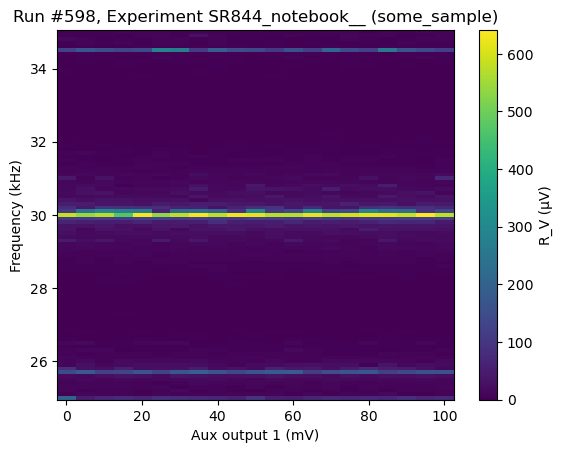

In [143]:
do1d(lockin1.aux_out1, 0, 0.1, 21, 0.05, Frequency_Buffer, do_plot=True)

#### Non-buffer measurements

The instrument also supports do1d and do2d measurements without buffer

Starting experimental run with id: 562. Using 'qcodes.dataset.do1d'


(results #562@C:\Users\Farzad\experiments.db
 -------------------------------------------
 lockin_frequency - numeric
 lockin_R_V - numeric,
 (<Axes: title={'center': 'Run #562, Experiment SR844_notebook__ (some_sample)'}, xlabel='Frequency (kHz)', ylabel='R_V (μV)'>,),
 (None,))

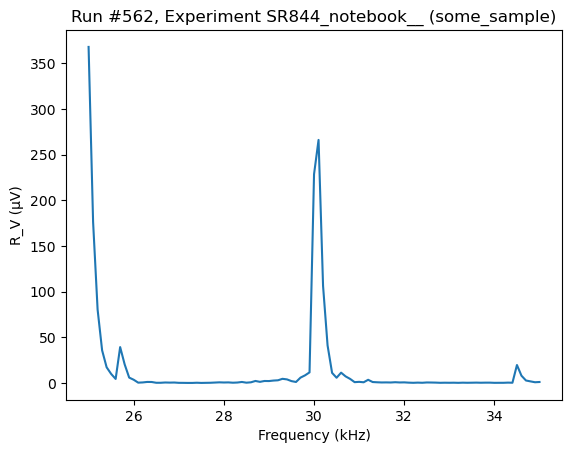

In [95]:
do1d(lockin1.frequency, 25000, 35000, 101, 0.05, lockin1.R_V, do_plot=True)

Starting experimental run with id: 565. Using 'qcodes.dataset.do2d'


(results #565@C:\Users\Farzad\experiments.db
 -------------------------------------------
 lockin_frequency - numeric
 lockin_aux_out1 - numeric
 lockin_X - numeric
 lockin_R_V - numeric,
 (<Axes: title={'center': 'Run #565, Experiment SR844_notebook__ (some_sample)'}, xlabel='Frequency (kHz)', ylabel='Aux output 1 (mV)'>,
  <Axes: title={'center': 'Run #565, Experiment SR844_notebook__ (some_sample)'}, xlabel='Frequency (kHz)', ylabel='Aux output 1 (mV)'>),
 (<matplotlib.colorbar.Colorbar at 0x26ca6ddc850>,
  <matplotlib.colorbar.Colorbar at 0x26ca6e02fd0>))

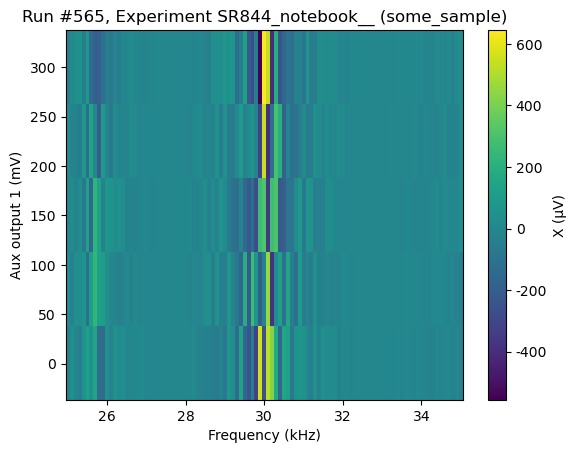

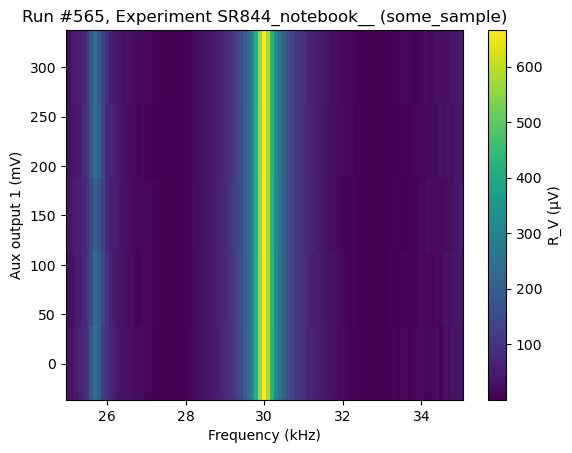

In [102]:
do2d(
    lockin1.frequency, 25000, 35000, 101, 0.05,
    lockin1.aux_out1, 0.001, 0.3, 5, 0.01,
    lockin1.X, lockin1.R_V,
    do_plot=True,
)